In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import string
import sys

import warnings
warnings.filterwarnings('ignore')

np.set_printoptions(precision=4, suppress=True)

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [2]:
cols = ["userId", "movieId", "rating"]
Rdf = pd.read_csv('C:/Work/UCLA/Winter 2021/219 Large Scale Data Mining Models and Algorithms/Project_3/ml-latest-small/ratings.csv',usecols = cols)
#Rdf = pd.read_csv('C:/Work/UCLA/Winter 2021/219 Large Scale Data Mining Models and Algorithms/Project_3/ml-latest-small/tp.csv',usecols = cols)
R = Rdf.pivot(index = "userId", columns = "movieId", values = "rating")
R.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [208]:
R = R.to_numpy()  #R is now the numpy Ratings matrix
m = R.shape[0]      #m is the number of users
n = R.shape[1]      #n is the number of movies

print("Number of users:", m)
print("Number of movies:", n)


Number of users: 610
Number of movies: 9724


## Q1. Sparsity

In [209]:
num_ratings = Rdf.shape[0]
sparsity = num_ratings/(m*n)

print("Sparsity is", sparsity)
print("Num of available ratings = ", num_ratings)
print("Num of possible ratings = ", m*n)


Sparsity is 0.016999683055613623
Num of available ratings =  100836
Num of possible ratings =  5931640


## Q2. Histogram showing frequency of rating values

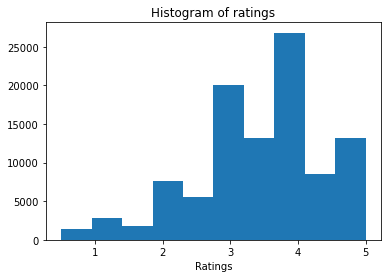

In [210]:
plt.hist(Rdf["rating"], bins = 10)
plt.title("Histogram of ratings")
plt.xlabel("Ratings")
plt.show()

## Q3. Distribution of number of ratings received among movies

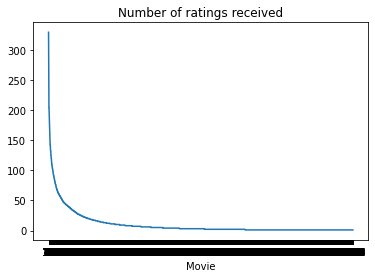

In [211]:
mov = Rdf['movieId'].value_counts()
mov = mov.to_numpy()

plt.plot(np.arange(1,n+1), mov)
plt.xticks(np.arange(1,n+1))
plt.title("Number of ratings received")
plt.xlabel("Movie")
plt.show()

## Q4. Distribution of the number of ratings among users

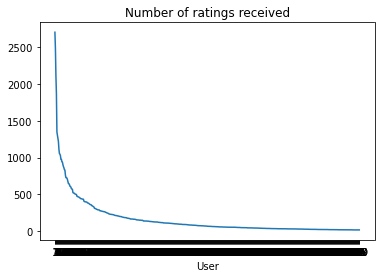

In [212]:
users = Rdf['userId'].value_counts()
users = users.to_numpy()

plt.plot(np.arange(1,m+1), users)
plt.xticks(np.arange(1,m+1))
plt.title("Number of ratings received")
plt.xlabel("User")
plt.show()

## Q5. Features of the ratings distribution

## Q6. Histogram of variance of the rating values received by each movie

Maximum variance is 5.0625
Minimum variance is 0.0


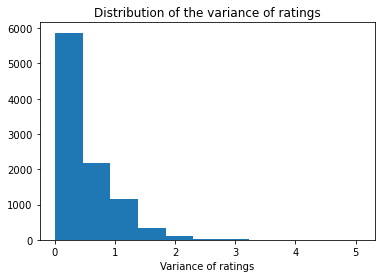

In [213]:
mov_var = Rdf[["movieId","rating"]].groupby(['movieId']).var(ddof=0) #Ref: ddof = 0 makes the divisor used in calculations N-ddof = N
mov_var = mov_var.to_numpy()
mov_var = np.squeeze(mov_var)

print("Maximum variance is", np.max(mov_var))
print("Minimum variance is",np.min(mov_var))
bins = np.ceil((np.max(mov_var) - np.min(mov_var))/0.5)
#print(bins)
plt.hist(mov_var, bins = int(bins))
plt.title("Distribution of the variance of ratings")
plt.xlabel("Variance of ratings")
plt.show()

## Q7. Pearson Correlation Coefficient

<font size="5">$\mu_u = \frac{\Sigma_{k \in I_u}r_{uk}}{size(I_u)}$</font>

## Q8. 

$I_u \cap I_v = \phi$ indicates that there were no common movies rated by both user $u$ and user $v$

## Q9. Mean centering

Since ratings ought to help us compare how much a user liked one movie over the others they watched, mean centered ratings are a better measure for this purpose. This is because mean centering removes the individual bias of users - some users give raw ratings in the higher ranges for all movies, and hence mean centering allows us to conclude that the now positive rated movies are the ones they prefer more than an average movie according to them.

In [4]:
#conda install -c conda-forge scikit-surprise

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\sriva\anaconda3

  added / updated specs:
    - scikit-surprise


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-surprise-1.1.1      |   py38h1e00858_1         567 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         567 KB

The following NEW packages will be INSTALLED:

  scikit-surprise    conda-forge/win-64::scikit-surprise-1.1.1-py38h1e00858_1




scikit-surprise-1.1. | 567 KB    |            |   0% 
scikit-surprise-1.1. | 567 KB    | 2          |   3% 
scikit-surprise-1.1. | 567 KB    | ########## | 100% 
scikit-surprise-1.1. | 567 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may n

## Q 10.

In [61]:
from surprise import Reader
from surprise import Dataset
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise import similarities
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise import accuracy

In [24]:
reader = Reader(rating_scale=(0.5, 5))
R_data = Dataset.load_from_df(Rdf[["userId", "movieId", "rating"]], reader)

sim_options = {'name': 'pearson',
              'user_based': True}

k_list = np.arange(2,101,2)
scores = []

for k in k_list:
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    pred = cross_validate(algo, R_data, cv = 10, verbose = False, n_jobs = -1)
    rmse = np.mean(pred['test_rmse'])
    rmae = np.mean(pred['test_mae'])
    scores.append([rmse, rmae])
    
scores_df = pd.DataFrame(scores, columns = ['Avg RMSE', 'Avg MAE'], index = k_list)

scores_df

,Avg RMSE,Avg MAE
2,1.017933,0.785485
4,0.944304,0.725557
6,0.919465,0.704632
8,0.908955,0.695544
10,0.901835,0.689066
12,0.898277,0.685962
14,0.894822,0.683049
16,0.894298,0.682314
18,0.891611,0.679696
20,0.891010,0.679194


<AxesSubplot:title={'center':'Cross validation - MAE'}, xlabel='k', ylabel='MAE'>

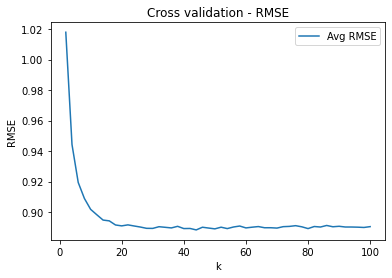

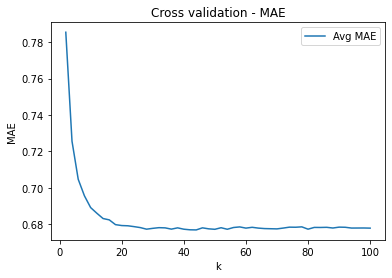

In [25]:
scores_df.plot(y = 'Avg RMSE', xlabel = "k", ylabel = "RMSE", title = "Cross validation - RMSE")
scores_df.plot(y = 'Avg MAE', xlabel = "k", ylabel = "MAE", title = "Cross validation - MAE")

## Q 11.

For RMSE, minimum k = 20, and RMSE(k=20) = 0.891

For MAE, minimum k = 28, and MAE (k=28) = 0.677

## Q 12.

In [62]:
def popular_movies(df):
    t = df[df['rating']>2] #entries with rating more than 2
    t_movies = t['movieId'].unique() #movies which had atleast one rating more than 2
    trim = df.loc[df['movieId'].isin(t_movies)]
    return trim

In [72]:
kf = KFold(n_splits=10)

k_list = np.arange(2,101,2)
k_list = np.arange(5,11,5)
scores = []

for k in k_list:
    
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    set_scores = []
    for trainset, testset in kf.split(R_data):
        #trainset and testset are lists made of tuples
        algo.fit(trainset)
        
        test_data = pd.DataFrame(testset, columns = ["userId", "movieId", "rating"])
        test_data = popular_movies(test_data)
        test_tuples = [tuple(x) for x in test_data.to_numpy()]
        
        predictions = algo.test(test_tuples)

        set_scores.append(accuracy.rmse(predictions, verbose=False))
    
    scores.append(sum(set_scores)/len(set_scores))

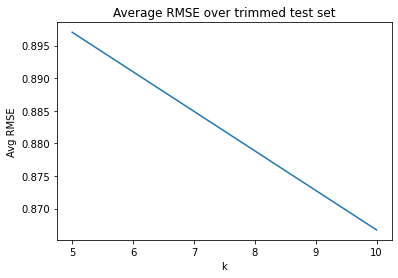

In [74]:
plt.plot(k_list, scores)
plt.xlabel('k')
plt.ylabel("Avg RMSE")
plt.title("Average RMSE over trimmed test set")
plt.show()

In [ ]:
def unpopular_movies(df):
    t = df[df['rating']<=2] #entries with rating less than or equal to 2
    t_movies = t['movieId'].unique() #movies which had atleast one rating less than or equal to 2
    trim = df.loc[df['movieId'].isin(t_movies)]
    return trim

In [ ]:
kf = KFold(n_splits=10)

k_list = np.arange(2,101,2)

scores = []

for k in k_list:
    
    algo = KNNWithMeans(k = k,sim_options=sim_options, verbose = False)
    set_scores = []
    for trainset, testset in kf.split(R_data):
        #trainset and testset are lists made of tuples
        algo.fit(trainset)
        
        test_data = pd.DataFrame(testset, columns = ["userId", "movieId", "rating"])
        test_data = unpopular_movies(test_data)
        test_tuples = [tuple(x) for x in test_data.to_numpy()]
        
        predictions = algo.test(test_tuples)

        set_scores.append(accuracy.rmse(predictions, verbose=False))
    
    scores.append(sum(set_scores)/len(set_scores))